In [1]:
from blocks.serialization import load
with open('ali_conditional_celeba.tar', 'rb') as src:
    main_loop = load(src)
ali, = main_loop.model.top_bricks
import theano.tensor as tensor
x = tensor.tensor4('features')
y = tensor.matrix('y')


Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 5.0% of memory, cuDNN 5105)


### reconstruction of celebA

In [2]:
# reconstruction

num_examples = 100
from ali import streams
_1, _2, data_stream = streams.create_celeba_data_streams(num_examples,
                                                           num_examples,
                                                           sources=('features', 'targets'),
                                                           )
x, y = next(data_stream.get_epoch_iterator())

AttributeError: 'module' object has no attribute 'tests'

In [3]:
from numpy.random import rand
embeddings = ali.embedder.apply(y).eval()
embeddings[0:1,0+10:20+10,0:1,0:1] = rand(1,20,1,1)
# embeddings[0] = np.zeros((1,256,1,1))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x_hat[0],[1,2,0])))
plt.axis('off')
plt.show()

NameError: name 'ali' is not defined

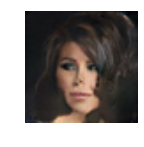

In [32]:
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x_hat[0],[1,2,0])))
plt.axis('off')
plt.show()

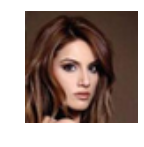

y: [0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1
 0 0 1]


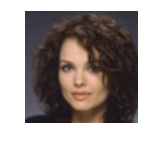

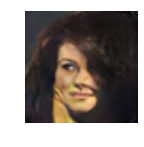

y: [0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 1 0]


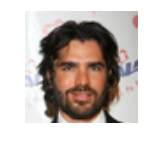

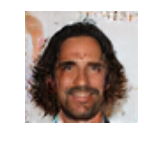

y: [0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1]


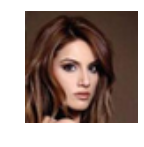

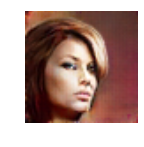

y: [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0
 0 1 1]


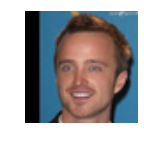

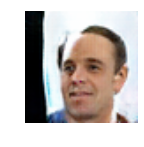

y: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1]


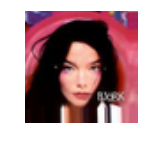

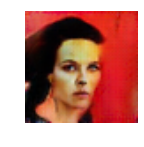

y: [0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1
 0 0 1]


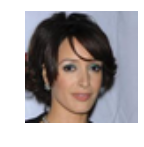

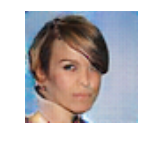

y: [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1
 0 0 1]


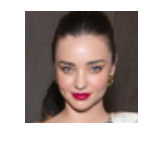

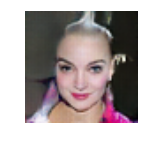

y: [0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0]


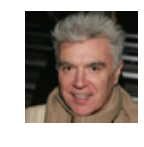

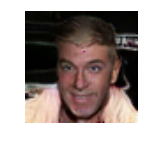

y: [1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1]


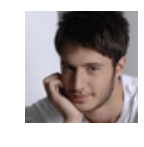

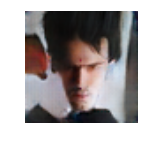

y: [0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1]


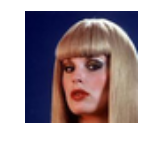

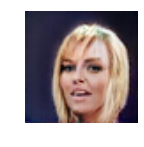

y: [0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1]


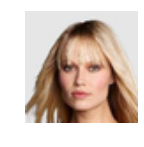

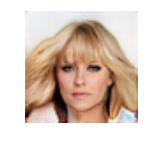

y: [0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1
 1 0 0]


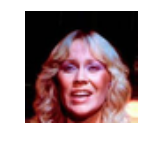

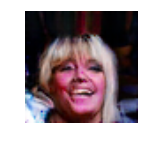

y: [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1]


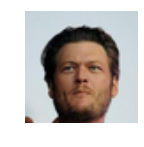

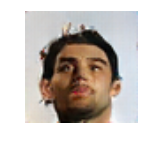

y: [1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1]


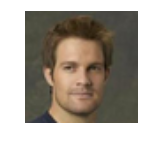

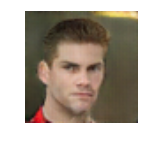

y: [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 1 0]


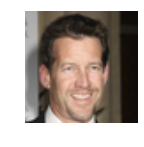

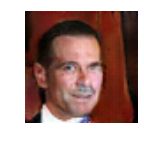

y: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0]


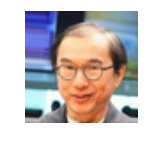

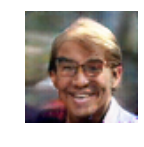

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x[2],[1,2,0])))
plt.axis('off')
plt.show()


embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings)  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
#     plt.imshow(np.squeeze(x[idx]))
    plt.imshow(np.squeeze(np.transpose(x[idx],[1,2,0])))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
#     plt.imshow(np.squeeze(x_hat[idx]))
    plt.imshow(np.squeeze(np.transpose(x_hat[idx],[1,2,0])))
    plt.axis('off')
    plt.show()


### CRS DATA

/home/hope-yao/anaconda2/lib/python2.7/site-packages/blocks/bricks/conv.py:344: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  ignore_border=self.ignore_border)


y: [1 1]


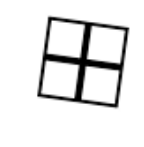

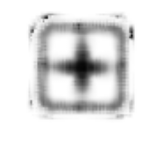

y_hat: [ 0.99997449  1.        ]
y: [1 1]


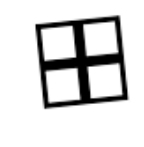

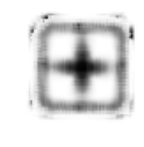

y_hat: [ 0.9999789  1.       ]
y: [0 0]


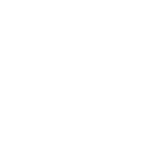

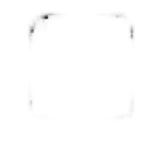

y_hat: [ 0.13668227  0.30976731]
y: [0 0]


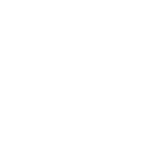

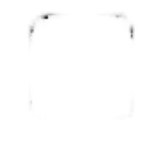

y_hat: [ 0.15129544  0.3005445 ]
y: [0 1]


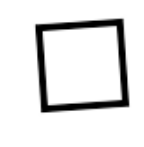

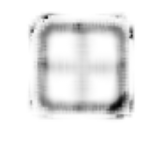

y_hat: [ 0.00106458  0.99996781]
y: [1 1]


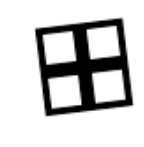

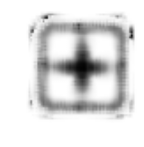

y_hat: [ 0.9999783  1.       ]
y: [0 0]


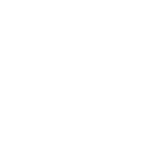

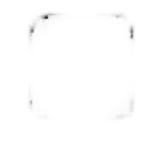

y_hat: [ 0.11673642  0.32468462]
y: [1 1]


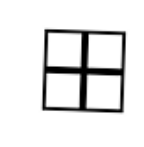

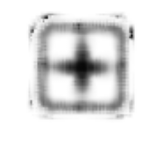

y_hat: [ 0.99997044  1.        ]
y: [0 1]


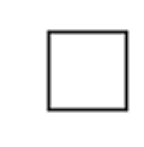

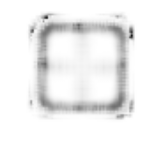

y_hat: [  3.56391043e-04   9.99503613e-01]
y: [1 1]


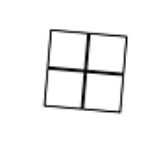

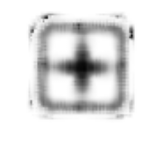

y_hat: [ 0.99996352  1.        ]
y: [0 1]


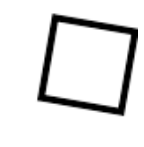

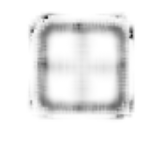

y_hat: [  7.84385949e-04   9.99856591e-01]
y: [0 0]


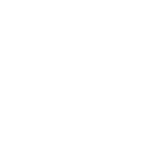

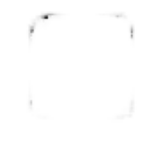

y_hat: [ 0.14960659  0.30135068]
y: [0 1]


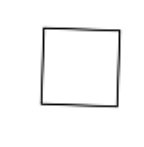

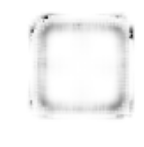

y_hat: [  4.93791362e-04   9.68414426e-01]
y: [1 1]


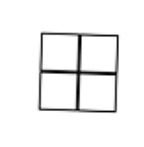

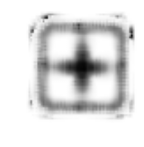

y_hat: [ 0.99996817  1.        ]
y: [0 0]


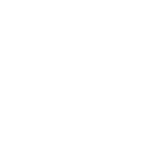

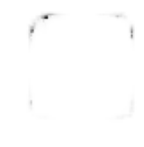

y_hat: [ 0.14031681  0.30730927]
y: [1 1]


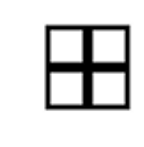

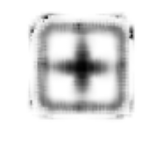

y_hat: [ 0.99997902  1.        ]


In [2]:
# reconstruction

num_examples = 100
from ali import streams
_1, _2, data_stream = streams.create_crs_data_streams(num_examples,
                                                           num_examples,
                                                           sources=('features', 'targets'),
                                                           )
x, y = next(data_stream.get_epoch_iterator())

embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings).eval()  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
y_hat = ali.classifier.apply(x_hat).eval()

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x[idx]))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print('y_hat: {}'.format(y_hat[idx]))

x_hat0 = x_hat[0]

In [165]:
x_hat.shape

(100, 1, 64, 64)

0


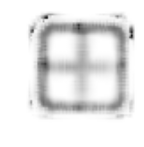

[ 0.99997449  1.        ]
1


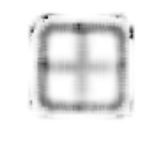

[ 0.9999789  1.       ]
2


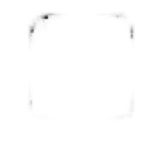

[ 0.13668227  0.30976731]
3


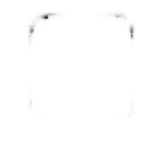

[ 0.15129544  0.3005445 ]
4


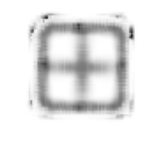

[ 0.00106458  0.99996781]
5


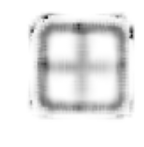

[ 0.9999783  1.       ]
6


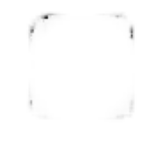

[ 0.11673642  0.32468462]
7


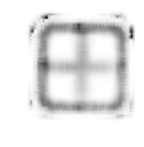

[ 0.99997044  1.        ]
8


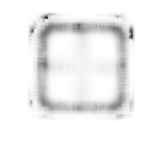

[  3.56391043e-04   9.99503613e-01]
9


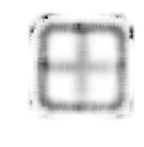

[ 0.99996352  1.        ]
10


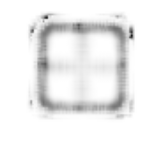

[  7.84385949e-04   9.99856591e-01]
11


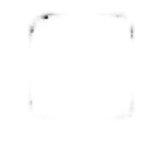

[ 0.14960659  0.30135068]
12


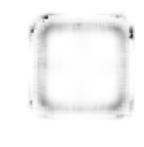

[  4.93791362e-04   9.68414426e-01]
13


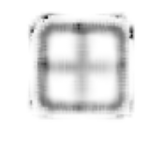

[ 0.99996817  1.        ]
14


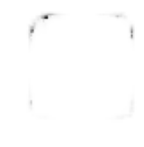

[ 0.14031681  0.30730927]
15


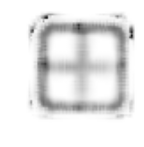

[ 0.99997902  1.        ]


In [3]:
z_sub = z_hat-z_hat[4]
yy = np.ones_like(y)
yy[:,1]=0
e_sub = ali.embedder.apply(yy)
x_hat = ali.decoder.apply(z_sub, e_sub).eval()  # G_x(z,e(y))

for idx in range(16):
    print(idx)
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])

z_sub0 = z_sub[0]
e_sub0 = e_sub[0]
x_sub0 = x_hat[0]



In [ ]:
z_sub = z_hat-z_hat[4]
e_sub = embeddings-embeddings[4]
x_hat = ali.decoder.apply(z_sub, e_sub).eval()  # G_x(z,e(y))


for idx in range(16):
    print(idx)
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])

z_sub1 = z_sub[0]
e_sub1 = e_sub[0]
x_sub1 = x_hat[0]


### reconstruct unseen data

In [166]:
BATCH_SIZE = 128
RATIO = 16
NLAT = 256/RATIO

y_b = tensor.stack( [tensor.ones((BATCH_SIZE,)), tensor.zeros((BATCH_SIZE,))], axis=1 )# (1,0)
embeddings = ali.embedder.apply(y_b)
z_b_hat = ali.theano_rng.normal(size=(BATCH_SIZE, NLAT, 1, 1))
x_b = ali.decoder.apply(z_b_hat ,embeddings)
y_b_hat = ali.classifier.apply(x_b)
y_b_hat = y_b_hat.reshape((BATCH_SIZE,2))
y_b_0 = tensor.stack( [tensor.zeros((BATCH_SIZE,)), tensor.zeros((BATCH_SIZE,))], axis=1 )# (0,0)
y_b_1 = tensor.stack( [tensor.ones((BATCH_SIZE,)), tensor.zeros((BATCH_SIZE,))], axis=1 )# (1,0)
y_b_2 = tensor.stack( [tensor.ones((BATCH_SIZE,)), tensor.ones((BATCH_SIZE,))], axis=1 )# (1,1)
# basis_cost  = - ( tensor.sum(y_b_0*tensor.log(y_b_hat+eps)) + tensor.sum((1-y_b_0)*tensor.log(1-y_b_hat+eps)) )
# basis_cost += - ( tensor.sum(y_b_1*tensor.log(y_b_hat+eps)) + tensor.sum((1-y_b_1)*tensor.log(1-y_b_hat+eps)) )
# basis_cost += - ( tensor.sum(y_b_2*tensor.log(y_b_hat+eps)) + tensor.sum((1-y_b_2)*tensor.log(1-y_b_hat+eps)) )
# basis_cost = tensor.sum ( 1./(10.- tensor.sum(tensor.sqr(y_b_hat-y_b_0),1)) + 1./(10.- tensor.sum(tensor.sqr(y_b_hat-y_b_1),1)) + 1./(10.- tensor.sum(tensor.sqr(y_b_hat-y_b_2),1)) )
basis_cost = -tensor.log(tensor.mean( tensor.sum(tensor.sqr(y_b_hat-y_b_0),1) + tensor.sum(tensor.sqr(y_b_hat-y_b_1),1) + tensor.sum(tensor.sqr(y_b_hat-y_b_2),1) ))
basis_cost.name = 'basis_cost'  # Basis cost is negative of cross entropy, but to be maximized

In [13]:
y_b_hat.eval()

array([[ 0.5570364 ,  0.99999905],
       [ 0.55207491,  0.99999905],
       [ 0.55477244,  0.99999905],
       [ 0.55466521,  0.99999905],
       [ 0.55265749,  0.99999905],
       [ 0.55400473,  0.99999905],
       [ 0.55398345,  0.99999905],
       [ 0.5517807 ,  0.99999905],
       [ 0.55206609,  0.99999893],
       [ 0.55567694,  0.99999893],
       [ 0.559802  ,  0.99999893],
       [ 0.54509622,  0.99999893],
       [ 0.55277854,  0.99999905],
       [ 0.55409807,  0.99999905],
       [ 0.55325872,  0.99999905],
       [ 0.55503851,  0.99999905],
       [ 0.55579883,  0.99999893],
       [ 0.56180418,  0.99999905],
       [ 0.55325413,  0.99999905],
       [ 0.55024284,  0.99999905],
       [ 0.55011028,  0.99999905],
       [ 0.55504709,  0.99999905],
       [ 0.54735827,  0.99999893],
       [ 0.55448616,  0.99999905],
       [ 0.55024236,  0.99999905],
       [ 0.55359411,  0.99999905],
       [ 0.55633026,  0.99999905],
       [ 0.55515152,  0.99999905],
       [ 0.55564398,

0


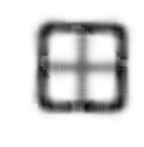

[ 0.60677135  0.99999905]
1


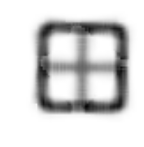

[ 0.60704184  0.99999905]
2


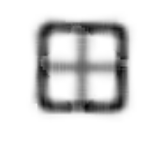

[ 0.00127406  0.91414207]
3


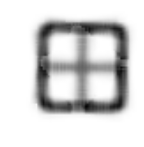

[ 0.0012739  0.9141016]
4


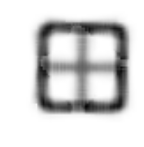

[ 0.00588916  0.99959904]
5


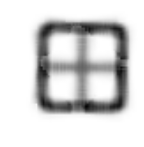

[ 0.60048229  0.99999905]
6


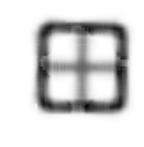

[ 0.00127326  0.91400141]
7


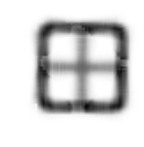

[ 0.60684371  0.99999905]
8


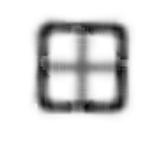

[ 0.0022548  0.9959693]
9


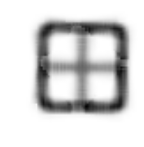

[ 0.58599645  0.99999905]
10


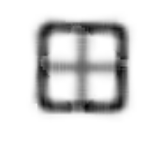

[ 0.00587685  0.99959725]
11


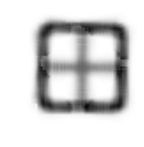

[ 0.00127388  0.91412449]
12


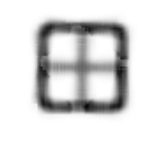

[ 0.00154593  0.98500133]
13


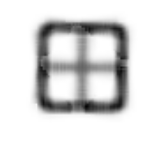

[ 0.58466172  0.99999905]
14


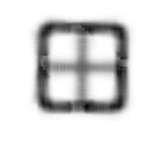

[ 0.0012736   0.91406626]
15


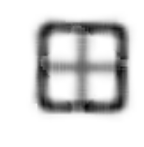

[ 0.60598183  0.99999905]


In [14]:
xx_b = x_b.eval()
for idx in range(16):
    print(idx)
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(xx_b[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])

In [15]:
import numpy as np

nn = np.load('/home/hope-yao/Documents/Data/rec_crs.npy')
dim = 64
crs = nn.item()['cross_img']#['cross_img']
crs = crs.reshape(crs.shape[0],1,dim,dim)
xx = crs[0:100]
yy = np.asarray([[1,0]]*100)
xx = xx.astype('float32')
yy = yy.astype('uint8')


y: [1 0]


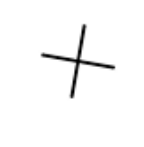

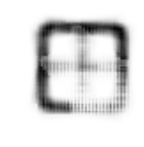

y_hat: [ 0.01979288  0.99996173]
y: [1 0]


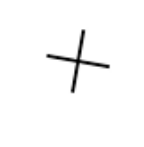

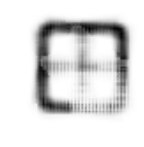

y_hat: [ 0.02487219  0.99996877]
y: [1 0]


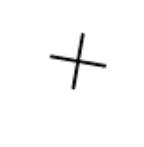

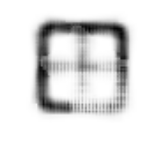

y_hat: [ 0.02998635  0.99997377]
y: [1 0]


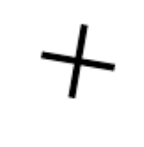

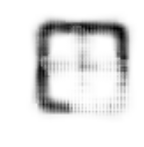

y_hat: [ 0.00296616  0.99972981]
y: [1 0]


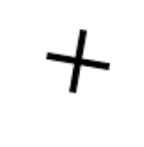

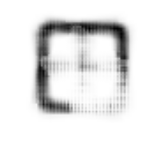

y_hat: [ 0.00385244  0.99978942]
y: [1 0]


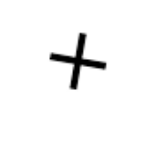

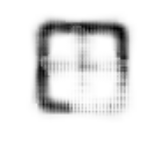

y_hat: [ 0.0048439   0.99983227]
y: [1 0]


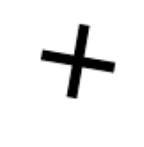

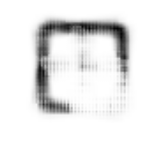

y_hat: [ 0.00115451  0.99911064]
y: [1 0]


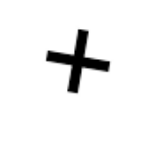

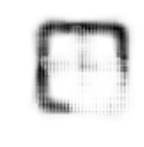

y_hat: [ 0.00145284  0.9993155 ]
y: [1 0]


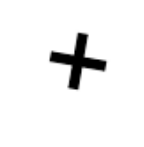

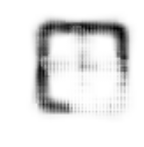

y_hat: [ 0.00179084  0.99946553]
y: [1 0]


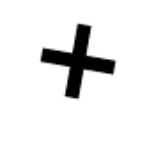

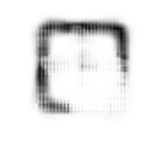

y_hat: [  7.15859118e-04   9.98002589e-01]
y: [1 0]


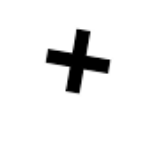

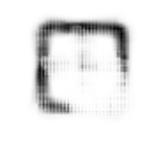

y_hat: [  8.73426790e-04   9.98480141e-01]
y: [1 0]


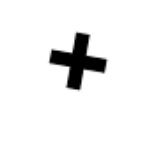

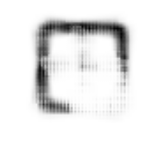

y_hat: [ 0.00104454  0.99882799]
y: [1 0]


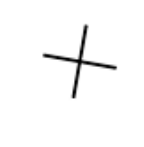

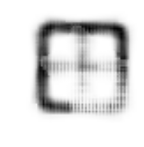

y_hat: [ 0.01925588  0.99996054]
y: [1 0]


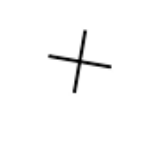

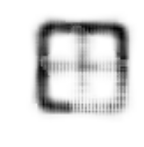

y_hat: [ 0.02420074  0.99996781]
y: [1 0]


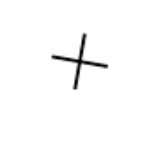

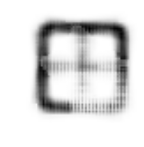

y_hat: [ 0.02926918  0.99997306]
y: [1 0]


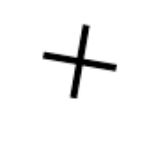

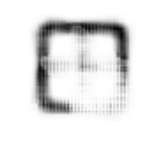

y_hat: [ 0.00290969  0.99972194]


In [16]:

import numpy as np
from random import sample

x = xx
y = yy

embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings).eval()  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
y_hat = ali.classifier.apply(x_hat).eval()

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x[idx]))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print('y_hat: {}'.format(y_hat[idx]))

# x_hat0 = x_hat[0]

### Add manually labeled data

In [46]:
# %reset
import numpy as np
from random import sample

nn = np.load('/home/hope-yao/Documents/Data/rec_crs.npy')
dim = 64

crs = nn.item()['rectcrs_img']#['cross_img']
crs = crs.reshape(crs.shape[0],1,dim,dim)
# crs_label = [[1,0]+[0]*0] * crs.shape[0]
crs_label = [[1,1]+[0]*0] * crs.shape[0]

rec = nn.item()['rect_img']
rec = rec.reshape(rec.shape[0],1,dim,dim)
rec_label = [[0,1]+[0]*0] * rec.shape[0]

datas = np.append(crs,rec,0)
labels = np.append(crs_label,rec_label,0)

ttn = 128*4
data = [datas[len(datas)/ttn*i] for i in range(ttn) ]
label = [labels[len(datas)/ttn*i] for i in range(ttn) ]
data = np.append(data,x_hat,0)
label = np.append(label,[[0,0]]*len(x_hat),0)
data = np.asarray(data)
label = np.asarray(label)

split = 0.2
l = len(data) #length of data
n1 = int(split*l)  # split for testing
n2 = l - n1
indices = sample(range(l),n1)

data_test = data[indices]
label_test = label[indices]

data_train = np.delete(data,indices,0)
label_train = np.delete(label,indices,0)

In [52]:
x_hat.shape

(100, 1, 64, 64)

In [50]:
# %reset
import h5py

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('rectcrs.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 2
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

## MNIST DATASET

In [130]:
% reset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
(mnist.train.images).shape, (mnist.train.labels).shape

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (55000, 10))

In [3]:
# %reset
import numpy as np
import h5py
data_train = mnist.train.images
label_train = mnist.train.labels
data_test = mnist.test.images
label_test = mnist.test.labels

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(1,28,28))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(1,28,28))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('Mnist28.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 10
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

NameError: name 'np' is not defined

## MNIST64 DATASET

In [131]:
import numpy as np
labels = mnist.train.labels
idx1 = idx2 = idx3 = idx4 = idx5 = idx6 = idx7 = idx8 = []
for i in range(mnist.train.labels.shape[0]):
    tmp = np.argmax(mnist.train.labels[i,:])
    if tmp == 1:
        idx1 = idx1 + [i]
    if tmp == 2:
        idx2 = idx2 + [i]
    if tmp == 3:
        idx3 = idx3 + [i]
    if tmp == 4:
        idx4 = idx4 + [i]
    if tmp == 5:
        idx5 = idx5 + [i]
    if tmp == 6:
        idx6 = idx6 + [i]
    if tmp == 7:
        idx7 = idx7 + [i]
    if tmp == 8:
        idx8 = idx8 + [i]        
        

In [132]:
images = mnist.train.images
data = []
label = []
pad = 2
nbatch = 400

for j in range(128*nbatch):
    print(j)
    imgs = np.zeros((64,64))
    labeli = []
    for i in range(4):
        kk = np.int(np.random.rand(1)[0]+0.5)
        # upperleft, lowerleft, upperright, lowerright
        if i==0:
            if not kk:
                img = images[np.random.choice(idx1)].reshape(28,28)
            else:
                img = images[np.random.choice(idx2)].reshape(28,28)
            imgs[0+pad:28+pad,0+pad:28+pad] = img
        if i==1:
            if not kk:
                img = images[np.random.choice(idx3)].reshape(28,28)
            else:
                img = images[np.random.choice(idx4)].reshape(28,28)
            imgs[28+pad+2*pad:2*28+pad+2*pad,0+pad:28+pad] = img
        if i==2:
            if not kk:
                img = images[np.random.choice(idx5)].reshape(28,28)
            else:
                img = images[np.random.choice(idx6)].reshape(28,28)
            imgs[0+pad+2*pad:28+pad+2*pad,28+pad:2*28+pad] = img
        if i==3:
            if not kk:
                img = images[np.random.choice(idx7)].reshape(28,28)
            else:
                img = images[np.random.choice(idx8)].reshape(28,28)
            imgs[28+pad+2*pad:2*28+pad+2*pad,28+pad+2*pad:2*28+pad+2*pad] = img
        labeli = labeli +[kk] 
    label = label + [labeli] 
    data = data + [imgs]
data = np.asarray(data)
label = np.asarray(label)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[0 1 1 0]


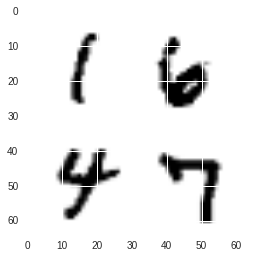

In [133]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
idx = 10
plt.imshow(np.squeeze(data[idx]))
print(label[idx])
plt.show()

In [134]:
import numpy as np
from random import sample

split = 0.2
l = len(data) #length of data
n1 = int(split*l)  # split for testing
n2 = l - n1
indices = sample(range(l),n1)

data = data.reshape(data.shape[0],1,data.shape[1],data.shape[2])
data_test = data[indices]
label_test = label[indices]

data_train = np.delete(data,indices,0)
label_train = np.delete(label,indices,0)

In [135]:
# %reset
import h5py

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('Mnist64.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 4
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

In [310]:
from theano import tensor
from blocks.bricks import LeakyRectifier, Logistic, Rectifier, Softmax, Activation
from ali.conditional_bricks import (EncoderMapping, Decoder,
                                    GaussianConditional, XZYJointDiscriminator,
                                    ConditionalALI, LeNet)
from blocks.initialization import IsotropicGaussian, Constant, Uniform

NCLASSES = 4
feature_maps = [16, 32, 64]
mlp_hiddens = [100]
output_size = NCLASSES
image_size = (64, 64)

conv_activations = [Rectifier() for _ in feature_maps]
mlp_activations = [Rectifier() for _ in mlp_hiddens] + [Logistic()]
convnet = LeNet(conv_activations, 1, image_size,
                filter_sizes=[(3, 3), (3, 3), (3, 3)],
                feature_maps=feature_maps,
                pooling_sizes=[(2, 2), (2, 2), (2, 2)],
                top_mlp_activations=mlp_activations,
                top_mlp_dims=mlp_hiddens + [output_size],
                border_mode='valid',
                weights_init=Uniform(width=.5),
                biases_init=Constant(0)
                )

convnet.push_initialization_config()
convnet.initialize()

classifier = convnet
x = tensor.tensor4('features')
y = tensor.matrix('targets')
BATCH_SIZE = 128
pred = classifier.apply(x)
EPS = 1e-8
classifier_cost = - ( tensor.sum(y*tensor.log(pred+EPS)) + tensor.sum((1-y)*tensor.log(1-pred+EPS)) )
# classifier_error = tensor.sum(tensor.sqr(y - pred))/BATCH_SIZE/NCLASSES
# pred = generator.apply(data_test).eval()
classifier_error = tensor.sum(tensor.abs_(y-pred))/BATCH_SIZE/NCLASSES
classifier_cost.name = 'classifier cost'
classifier_error.name = 'classifier error'


In [305]:
pred = np.asarray([[1,0],[0,0.8]])
y = np.asarray([[1,0],[0,1]])
classifier_cost = - ( tensor.sum(y*tensor.log(pred+EPS)) + tensor.sum((1-y)*tensor.log(1-pred+EPS)) )


In [314]:
from blocks.algorithms import GradientDescent, CompositeRule, Restrict, Scale
from collections import OrderedDict
from theano import grad
from blocks.algorithms import Adam, RMSProp, Momentum
from blocks.select import Selector
from blocks.extensions import FinishAfter, Timing, Printing, ProgressBar
from blocks.extensions.monitoring import DataStreamMonitoring
from ali.streams import create_celeba_data_streams, create_crs_data_streams, create_mnist64_data_streams
from blocks.extensions.saveload import Checkpoint
from blocks.main_loop import MainLoop
from blocks.model import Model

MONITORING_BATCH_SIZE = 128
streams = create_mnist64_data_streams(BATCH_SIZE, MONITORING_BATCH_SIZE,
                                     sources=('features', 'targets'))
main_loop_stream, train_monitor_stream, valid_monitor_stream = streams

classifier_parameters = list(Selector([classifier]).get_parameters().values())
LEARNING_RATE_C = 1e-2
# step_rule_c = RMSProp(learning_rate=LEARNING_RATE_C)
# # step_rule_c = Momentum(learning_rate=LEARNING_RATE_C,momentum = 0.99)

# gradients = OrderedDict()
# gradients.update(
#     zip(classifier_parameters,
#         grad(classifier_cost, classifier_parameters)))
# classify_algorithm = GradientDescent(cost=classifier_cost,
#                                     gradients=gradients,
#                                     parameters=classifier_parameters,
#                                     step_rule=step_rule_c)

classify_algorithm = GradientDescent(
    cost=classifier_cost, parameters=classifier_parameters,
    step_rule=Scale(learning_rate=0.0001))

# classifier_monitor = ()
extensions = [
    Timing(),
    FinishAfter(after_n_epochs=100),
    DataStreamMonitoring(
        [classifier_cost, classifier_error], train_monitor_stream, prefix="train"),
    DataStreamMonitoring(
        [classifier_cost, classifier_error], valid_monitor_stream, prefix="valid"),
    Checkpoint('./test.ckpt', after_epoch=True, after_training=True,
               use_cpickle=True),
    ProgressBar(),
    Printing(),
]
classify_loop = MainLoop(data_stream=main_loop_stream,
                         algorithm=classify_algorithm,
                         model=Model(classifier_cost), 
                         extensions=extensions)
print('classifier training...')
classify_loop.run()
print('classifier training done...')

classifier training...

-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 time_initialization: 1.74006009102
	 train_classifier cost: nan
	 train_classifier error: nan
	 valid_classifier cost: nan
	 valid_classifier error: nan



Epoch 0, step 32 |######################################| Elapsed Time: 0:00:02



-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 32
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 32:
	 saved_to: ('./test.ckpt',)
	 time_read_data_this_epoch: 0.089875459671
	 time_read_data_total: 0.089875459671
	 time_train_this_epoch: 0.330967903137
	 time_train_total: 0.330967903137
	 train_classifier cost: nan
	 train_classifier error: nan
	 valid_classifier cost: nan
	 valid_classifier error: nan



Epoch 1, step 32 |######################################| Elapsed Time: 0:00:02



-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: True
	 epoch_started: False
	 epochs_done: 2
	 iterations_done: 64
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 64:
	 epoch_interrupt_received: True
	 saved_to: ('./test.ckpt',)
	 time_read_data_this_epoch: 0.0901803970337
	 time_read_data_total: 0.180055856705
	 time_train_this_epoch: 0.593623638153
	 time_train_total: 0.92459154129
	 train_classifier cost: nan
	 train_classifier error: nan
	 valid_classifier cost: nan
	 valid_classifier error: nan


-------------------------------------------------------------------------------
TRAINING HAS BEEN FINISHED:
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_

In [255]:
# % reset
from blocks.serialization import load

main_loop = load(open('test.ckpt', "rb"))
generator = main_loop.model.get_top_bricks()[-1]

In [256]:
from ali.streams import create_celeba_data_streams, create_crs_data_streams, create_mnist64_data_streams
BATCH_SIZE = 128
MONITORING_BATCH_SIZE = 128

streams = create_mnist64_data_streams(BATCH_SIZE, MONITORING_BATCH_SIZE,
                                     sources=('features', 'targets'))
main_loop_stream, train_monitor_stream, valid_monitor_stream = streams

In [257]:
train_test, label_test = next(valid_monitor_stream.data_stream.get_epoch_iterator())

In [258]:
from theano import tensor

pred = generator.apply(train_test).eval()
(tensor.sum(tensor.abs_(label_test-pred))/BATCH_SIZE).eval()
# np.sum(abs(label_test-pred))/len(label_test)

ERROR (theano.gof.opt): Optimization failure due to: local_conv_gpu_conv
ERROR (theano.gof.opt): node: AbstractConv2d{convdim=2, border_mode='valid', subsample=(1, 1), filter_flip=True, imshp=(None, 32, 14, 14), kshp=(64, 32, 3, 3), filter_dilation=(1, 1)}(pool_1_apply_output, HostFromGpu.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/opt.py", line 2809, in local_conv_gpu_conv
    inps[0] = as_cuda_ndarray_variable(inps[0])
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/basic_ops.py", line 46, in as_cuda_ndarray_variable
    return gpu_from_host(tensor_x)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/gof/op.py", line 604, in __call__
    node = self.make_no

array(1.9339765682911578)

In [142]:
(y_pred+0.5).astype(int)

array([[0, 1, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 1, 0],
       ..., 
       [0, 1, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 1, 0]])

In [143]:
y_test

array([[0, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 1, 1, 0],
       ..., 
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 1, 0]], dtype=uint8)

### Keras MNIST64

In [144]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers

batch_size = 128
epochs = 50


img_rows, img_cols = 64, 64
num_classes = 4
from fuel.datasets import MNIST28, MNIST64
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
import numpy as np
mnist_test = MNIST64(("valid",))
mnist_test_stream = DataStream.default_stream(
    mnist_test,
    iteration_scheme=ShuffledScheme(
        mnist_test.num_examples, batch_size))
x,y = mnist_test_stream.data_stream.data_stream.dataset.data_sources
if K.image_data_format() == 'channels_first':
    x = x.reshape(x.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x = x.reshape(x.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train, x_test = x[0:np.int(0.8*len(x))], x[np.int(0.8*len(x)):]
y_train, y_test = y[0:np.int(0.8*len(x))], y[np.int(0.8*len(x)):]
print(x_train.shape,y_train.shape)

# # input image dimensions
# num_classes = 10
# img_rows, img_cols = 28, 28
#
# # the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)
#
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
#
# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(8192, 64, 64, 1) (8192, 4)
Train on 8192 samples, validate on 2048 samples
Epoch 1/50
8192/8192 [==============================] - 3s - loss: 0.2488 - acc: 0.3099 - val_loss: 0.2470 - val_acc: 0.2217
Epoch 2/50
8192/8192 [==============================] - 3s - loss: 0.2417 - acc: 0.3130 - val_loss: 0.2306 - val_acc: 0.3521
Epoch 3/50
8192/8192 [==============================] - 3s - loss: 0.2129 - acc: 0.3944 - val_loss: 0.1955 - val_acc: 0.4614
Epoch 4/50
8192/8192 [==============================] - 3s - loss: 0.1816 - acc: 0.4368 - val_loss: 0.1754 - val_acc: 0.4038
Epoch 5/50
8192/8192 [==============================] - 3s - loss: 0.1630 - acc: 0.4614 - val_loss: 0.1629 - val_acc: 0.4048
Epoch 6/50
8192/8192 [==============================] - 3s - loss: 0.1532 - acc: 0.4664 - val_loss: 0.1556 - val_acc: 0.4971
Epoch 7/50
8192/8192 [==============================] - 3s - loss: 0.1476 - acc: 0.4630 - val_loss: 0.1505 - val_acc: 0.5176
Epoch 8/50
8192/8192 [===========================

In [145]:
y_pred=model.predict_proba(x_test)

1440/2048 [====================>.........] - ETA: 0s

In [146]:
np.sum(np.abs(y_test[0:1000] - (y_pred[0:1000]+0.5).astype('int')))

851

In [151]:
y_pred_train=model.predict_proba(x_train[0:10000])

7296/8192 [=========================>....] - ETA: 0s

In [152]:
np.sum(np.abs(y_train[0:1000] - (y_pred_train[0:1000]+0.5).astype('int')))

526